In [70]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
df = pd.read_csv('churn_data.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [6]:
df = df.drop(columns=['RowNumber'], axis=1)

In [7]:
continuous_columns = df.select_dtypes(include=[np.number]).drop('Exited',1)
print(f"count of numeric_features {continuous_columns.shape[1]}")
continuous_columns = continuous_columns.columns.to_list()
continuous_columns = continuous_columns[1:]
continuous_columns

count of numeric_features 9


['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [8]:
cat_feature_num = [
    feature for feature in continuous_columns
    if len(df[feature].unique())<20
]
categorical_columns = df.select_dtypes(include=[np.object]).columns.to_list()
categorical_columns = list(categorical_columns + cat_feature_num)
categorical_columns = categorical_columns[1:]
categorical_columns

['Geography',
 'Gender',
 'Tenure',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember']

In [9]:
continuous_columns = list(set(continuous_columns) - set(categorical_columns))
continuous_columns

['Age', 'EstimatedSalary', 'Balance', 'CreditScore']

In [10]:
final_transformers = list()

for cont_col in continuous_columns:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    final_transformers.append((cont_col, transfomer))
    
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Exited', 1), 
                                                    df['Exited'], random_state=0)

In [12]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [13]:
result = []

### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

Log_reg

In [22]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10 ,scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
pipeline.fit(X_train, y_train)
y_score = pipeline.predict_proba(X_test)[:, 1]

CV score is 0.8302294837919904+-0.01810443335415567


In [23]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)


fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

log_reg = roc_auc_score(y_test, y_score)

result.append({"method":"log_reg","roc_auc" : log_reg, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std
              })

Best Threshold=0.310532, F-Score=0.586, Precision=0.529, Recall=0.656


Random_forest

In [26]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42, n_jobs=-1)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8476459168308782+-0.014365541190265774


In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)


fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

RandomForestClassifier = roc_auc_score(y_test, y_score)

result.append({"method":"RandomForest","roc_auc" : RandomForestClassifier, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std})

Best Threshold=0.360000, F-Score=0.638, Precision=0.615, Recall=0.662


Xgboost

In [28]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier(random_state = 42, n_jobs=-1)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:00] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:11:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CV score is 0.8445497768356806+-0.017222824620210037
[16:11:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)


fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

XGBoost_classifier = roc_auc_score(y_test, y_score)

result.append({"method":"XGboost","roc_auc" : XGBoost_classifier, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std
              })

Best Threshold=0.327785, F-Score=0.626, Precision=0.604, Recall=0.650


Catboost

In [30]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42, silent=True, thread_count = -1)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8613433625505232+-0.01385255486296977


In [31]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)


fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Catb_classifier = roc_auc_score(y_test, y_score)

result.append({"method":"Catboost","roc_auc" : Catb_classifier, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std})

Best Threshold=0.309320, F-Score=0.642, Precision=0.597, Recall=0.695


LightGBM

In [32]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state = 42, silent=True)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.8556674658320744+-0.014996778233921091


In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)


fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Lgbm_classifier = roc_auc_score(y_test, y_score)

result.append({"method":"Lgbm","roc_auc" : Lgbm_classifier, "fscore" : fscore[ix],
               "precision" : precision[ix], "recall" : recall[ix],
               "cv_score" : cv_score, "cv_score_std" : cv_score_std})

Best Threshold=0.361180, F-Score=0.639, Precision=0.633, Recall=0.646


### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [37]:
pd.DataFrame(result).sort_values('fscore', ascending=False)

,method,roc_auc,fscore,precision,recall,cv_score,cv_score_std
3,Catboost,0.877038,0.642468,0.596965,0.695481,0.861343,0.013853
4,Lgbm,0.870491,0.639456,0.632692,0.646365,0.855667,0.014997
1,RandomForest,0.860872,0.637654,0.614964,0.662083,0.847646,0.014366
2,XGboost,0.860913,0.626301,0.604015,0.650295,0.844550,0.017223
0,log_reg,0.837661,0.585965,0.529319,0.656189,0.830229,0.018104


Вывод : лучший результат показывает LightGbm хоть у Catbosst и выше fscore но в данной задаче нам нужено как хорошо предсказывать целевой класс , так и хорошо отделять его из всех обьектов.

### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

Confusion matrix, without normalization
[[1800  191]
 [ 181  328]]


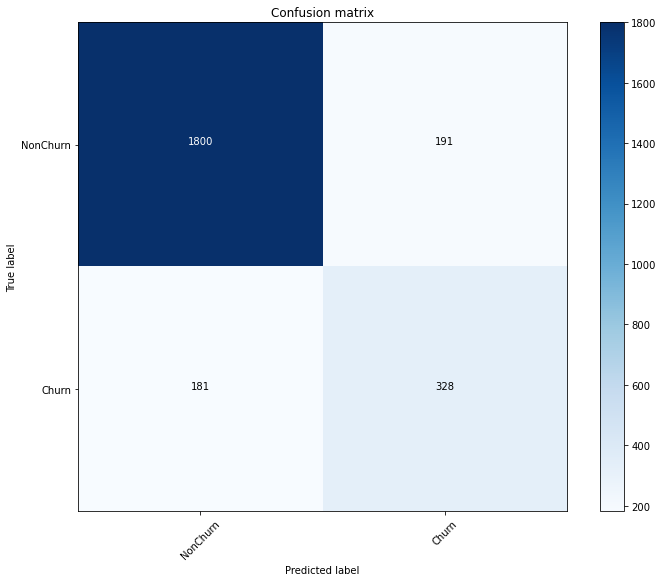

In [42]:
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [43]:
cnf_matrix

array([[1800,  191],
       [ 181,  328]])

In [60]:
TP = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TN = cnf_matrix[1][1]

In [68]:
print(f'прибыль {(2 * TP) + FP}') # Прибыль принесут TP и только на FP нужно будет тратиться на удержание
print(f'убыток {TN + 2*(FN)}') # TN уйдут и так а на FN будут затраты на привлечение и они уйдут 
print(f'при привлечении прибыл равна {((2 * TP) + FP) - (TN + 2*(FN)) }')

прибыль 3791
убыток 690
при привлечении прибыл равна 3101


### 4.(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [75]:
params={'classifier__num_leaves':[10, 15, 20],
        'classifier__lambda_l2':[200, 250, 300],
        'classifier__learning_rate':[0.01 , 0.05, 0.1],
        'classifier__n_jobs':[-1],
        'classifier__n_estimators':[300, 500, 1000, 2000],
        }

In [77]:
%%time
grid = GridSearchCV(classifier,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will b

{'classifier__lambda_l2': 200,
 'classifier__learning_rate': 0.05,
 'classifier__n_estimators': 1000,
 'classifier__n_jobs': -1,
 'classifier__num_leaves': 10}

In [78]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LGBMClassifier(random_state = 42, silent=True, lambda_l2=200,
                                 learning_rate=0.05, n_estimators=1000, num_leaves=10, n_jobs=-1
                                 )),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will be ignored. Current value: lambda_l2=200
[LightGBM] [Warning] lambda_l2 is set=200, reg_lambda=0.0 will b

In [79]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score)


fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.418740, F-Score=0.641, Precision=0.668, Recall=0.617


(опционально) Еще раз провести оценку экономической эффективности

Confusion matrix, without normalization
[[1835  156]
 [ 196  313]]


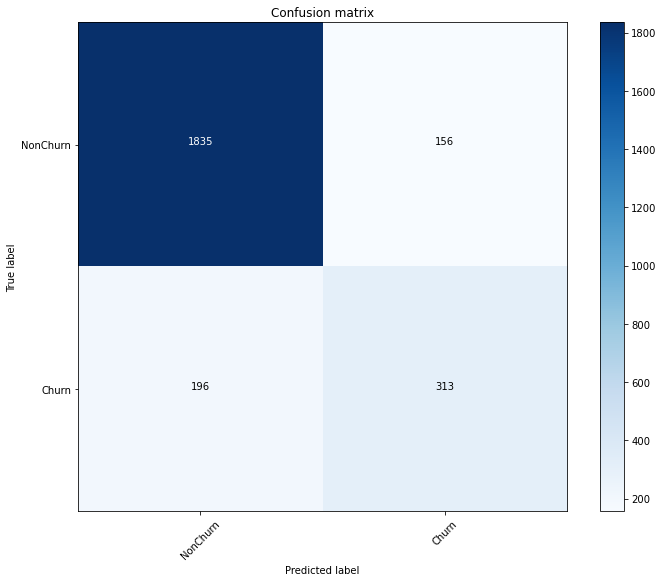

In [80]:
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [81]:
TP = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TN = cnf_matrix[1][1]

In [82]:
print(f'прибыль {(2 * TP) + FP}') # Прибыль принесут TP и только на FP нужно будет тратиться на удержание
print(f'убыток {TN + 2*(FN)}') # TN уйдут и так а на FN будут затраты на привлечение и они уйдут 
print(f'при привлечении прибыл равна {((2 * TP) + FP) - (TN + 2*(FN)) }')

прибыль 3826
убыток 705
при привлечении прибыл равна 3121
